##**UTILITY FUNCTIONS**

In [ ]:
import numpy as np
import pandas as pd
import warnings
from typing import List, Tuple, Dict


def split_data(X, y, test_size=0.1, seed=None):
    # shuffle data
    np.random.seed(seed)
    perm = np.random.permutation(X.index)
    X = X.loc[perm]
    y = y.loc[perm]
    
    # split into training and test sets
    n_samples = X.shape[0]
    if isinstance(test_size, float):
        if test_size <= 0 or test_size >= 1:
            raise ValueError("The test size should fall in the range (0,1)")
        n_train = n_samples - round(test_size*n_samples)
    elif isinstance(test_size, int):
        n_train = n_samples - test_size
    else:
        raise ValueError("Improper type \'%s\' for test_size" % type(test_size))

    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]

    return X_train, X_test, y_train, y_test

def encode_one_hot(data): # note: pd.get_dummies(df) does the same
    # https://www.kite.com/python/answers/how-to-do-one-hot-encoding-with-numpy-in-python
    one_hot = np.zeros((data.size, data.max()+1))
    rows = np.arange(data.size)
    one_hot[rows, data] = 1
    return one_hot

def check_RandomState(random_state):
    """ Parse different input types for the random state"""
    if  random_state is None: 
        rng = np.random.RandomState() 
    elif isinstance(random_state, int): 
        # seed the random state with this integer
        rng = np.random.RandomState(random_state) 
    elif isinstance(random_state, np.random.RandomState):
        rng = random_state
    else:
        raise ValueError ("improper type \'%s\' for random_state parameter" % type(random_state))
    return rng

def check_sample_size(sample_size, n_samples: int):
    if sample_size is None:
        n = n_samples
    elif isinstance(sample_size, int):
        if sample_size == 1:
            warnings.warn("Interpreting sample_size as 1 sample. Use sample_size=1.0 for 100% of the data")
        n = min(sample_size, n_samples)
    elif isinstance(sample_size, float):
        frac = min(sample_size, 1)
        n = int(frac*n_samples)
    else:
        raise ValueError("Improper type \'%s\' for sample_size" %type(sample_size))
    return n

def confusion_matrix(y_actual, y_pred):
    """ Returns a confusion matrix where the rows are the actual classes, and the columns are the predicted classes"""
    if y_actual.shape != y_pred.shape:
        raise ValueError ("input arrays must have the same shape, {}!={}".format(y_actual.shape, y_pred.shape))
    n = max(max(y_actual), max(y_pred)) + 1
    C = np.zeros((n, n), dtype=int)
    for label_actual in range(n):
        idxs_true = (y_actual == label_actual)
        for label_pred in range(n):
            C[label_actual, label_pred] = sum(y_pred[idxs_true] == label_pred)
    return C

def calc_f1_score(y_actual, y_pred) -> Tuple[float]:
    C = confusion_matrix(y_actual, y_pred)
    if C.shape[0] != 2:
        raise ValueError ("input arrays must only have binary values")
    recall    = C[1][1]/(C[1][0]+C[1][1]) #true positive/actual positive
    precision = C[1][1]/(C[0][1]+C[1][1]) #true positive/predicted positive
    if (recall == 0) or (precision == 0):
        f1 = 0
    else:
        f1 = 2 * recall*precision/(recall + precision) # = 2/((1/recall)+(1/precision))

    print("Recall: {:.4f}".format(recall))
    print("Precision: {:.4f}".format(precision))
    print("F1 Score: {:.4f}".format(f1))


##**DECISION TREE FUNCTIONS**

In [ ]:
import warnings
def gini_score(counts: List[int]) -> float: 
    score = 1
    n = sum(counts)
    for c in counts:
        p = c/n
        score -= p*p
    return score

class DecisionTree:
    def __init__(self, max_depth=None, max_features=None, min_samples_leaf=1, random_state=None):
        self.max_depth = max_depth
        self.max_features = max_features
        self.min_samples_leaf = min_samples_leaf
        self.RandomState = check_RandomState(random_state)

        # initialise internal variables
        self.tree_ = BinaryTree() 
        self.n_samples = []
        self.values = []
        self.impurities = []
        self.split_features = []
        self.split_values = []
        self.n_features = None
        self.n_classes = None
        self.features = None
        self.size = 0 # current node = size - 1
        
    def fit(self, X, Y):
        if Y.ndim == 1:
            Y = encode_one_hot(Y) # one-hot encoded y variable
        elif Y.shape[1] == 1:
            Y = encode_one_hot(Y) # one-hot encoded y variable

        # set internal variables
        self.n_features = X.shape[1]
        self.n_classes = Y.shape[1]
        self.features = X.columns
        self.max_depth_ = float('inf') if self.max_depth is None else self.max_depth
        if self.max_features is not None:
            if self.max_features is 'sqrt':
                n = int(np.sqrt(self.n_features))
            elif isinstance(self.max_features, int):
                n = min(self.max_features, self.n_features)
            else:
                raise Exception('Unknown parameter \'%s\' for max_features' % self.max_features)
        else:
            n = self.n_features 
        self.n_features_split = n

        # initial split which recursively calls itself
        self._split_node(X, Y) 

        # set attributes
        self.feature_importances_ = self.impurity_feature_importance()
        self.depths = self.tree_.find_depths()

    def get_n_splits(self) -> int:
        "The number of nodes (number of parameters/2) not counting the leaves in the tree"
        return self.tree_.n_splits
    
    def get_n_leaves(self) -> int:
        "The number of leaves (nodes without children) in the tree"
        return self.tree_.n_leaves

    def get_max_depth(self) -> int:
        "The maximum depth in the tree"
        return self.tree_.get_max_depth(0)

    def is_leaf(self, node_id: int) -> bool:
        return self.tree_.is_leaf(node_id)
    
    def split_name(self, node_id: int) -> str:
        return self.features[self.split_features[node_id]]

    def _set_defaults(self, node_id: int, Y):
        val = Y.sum(axis=0)
        self.values.append(val)
        self.impurities.append(gini_score(val))
        self.split_features.append(None)
        self.split_values.append(None)
        self.n_samples.append(Y.shape[0])
        self.tree_.add_node()
    
    def _split_node(self, X0, Y0):
        stack = [(X0, Y0, -1, -1, 0)] # stack = [(X, Y, parent, side, depth)]
        while stack:
            X, Y, parent, side, depth = stack.pop()
            node_id = self.size
            self.size += 1
            self._set_defaults(node_id, Y)
            if side is 0:
                self.tree_.set_left_child(parent, node_id)
            elif side is 1:
                self.tree_.set_right_child(parent, node_id)
            if self.impurities[node_id] == 0: # only one class in this node
                continue
            
            # random shuffling removes any bias due to the feature order
            features = self.RandomState.permutation(self.n_features)[:self.n_features_split]

            # make the split
            best_score = float('inf')
            for i in features:
                best_score= self._find_bettersplit(i, X, Y, node_id, best_score)
            if best_score == float('inf'):
                continue


            # make children
            if depth < self.max_depth_: 
                x_split = X.values[:, self.split_features[node_id]]
                lhs = np.nonzero(x_split<=self.split_values[node_id])
                rhs = np.nonzero(x_split> self.split_values[node_id])
                stack.append((X.iloc[rhs], Y[rhs[0], :], node_id, 1, depth+1)) # right first in, last out
                stack.append((X.iloc[lhs], Y[lhs[0], :], node_id, 0, depth+1)) # left first out

    
    def _find_bettersplit(self, var_idx: int, X, Y, node_id: int, best_score:float) -> float:
        X = X.values[:, var_idx] 
        n_samples = self.n_samples[node_id]

        # sort the variables. 
        order = np.argsort(X)
        X_sort, Y_sort = X[order], Y[order, :]

        #Start with all on the right. Then move one sample to left one at a time
        rhs_count = Y.sum(axis=0)
        lhs_count = np.zeros(rhs_count.shape)
        for i in range(0, len(X_sort)-1):
            xi, yi = X_sort[i], Y_sort[i, :]
            lhs_count += yi;  rhs_count -= yi
            if (xi == X_sort[i+1]) or (sum(lhs_count) < self.min_samples_leaf):
                continue
            if sum(rhs_count) < self.min_samples_leaf:
                break
            # Gini Impurity
            lhs_gini = gini_score(lhs_count)
            rhs_gini = gini_score(rhs_count)
            curr_score = (lhs_gini * lhs_count.sum() + rhs_gini * rhs_count.sum())/n_samples
            if curr_score < best_score:
                self.split_features[node_id] = var_idx
                best_score = curr_score
                self.split_values[node_id]= (xi + X_sort[i+1])/2
        return best_score

    def _predict_row(self, xi):
        next_node = 0
        while not self.is_leaf(next_node):
            left, right = self.tree_.get_children(next_node)
            next_node = left if xi[self.split_features[next_node]] <= self.split_values[next_node] else right
        return self.values[next_node]

    def _predict_batch(self, X, node=0):
        # Helper function for predict_prob(). Predicts multiple batches of a row at time. Faster than _predict_row(self, xi)
        if self.is_leaf(node):
            return self.values[node]
        if len(X) == 0:
            return np.empty((0, self.n_classes))
        left, right = self.tree_.get_children(node)

        lhs = X[:, self.split_features[node]] <= self.split_values[node]
        rhs = X[:, self.split_features[node]] >  self.split_values[node]

        probs = np.zeros((X.shape[0], self.n_classes))
        probs[lhs] = self._predict_batch(X[lhs], node=left)
        probs[rhs] = self._predict_batch(X[rhs], node=right)
        return probs

    def predict_prob(self, X):
        "Return the probability in the final leaf for each class, given as the fraction of each class in that leaf"
        if X.values.ndim == 1:
            probs = np.array([self._predict_row(X)])
        else:
            #start_time = time.time()
            #probs = np.apply_along_axis(self._predict_row, 1, X.values) # slow because this is a for loop
            probs = self._predict_batch(X.values)
            #end_time = time.time()
            #print('%.1fms' % ((end_time-start_time)*1000))
            probs /= np.sum(probs, axis=1)[:, None]
        return probs

    def predict(self, X):
        "Return the most likely class in the final leaf"
        probs = self.predict_prob(X)
        return np.nanargmax(probs, axis=1)

    def predict_count(self, X):
        "Return the sample count in the final leaf for each class"
        if X.values.ndim == 1:
            return np.array([self._predict_row(X.values)])
        return np.apply_along_axis(self._predict_row, 1, X.values)

    def impurity_feature_importance(self):
        """Calculate feature importance weighted by the number of samples affected by this feature at each split point. """
        feature_importances = np.zeros(self.n_features)
        total_samples = self.n_samples[0]
        for node in range(len(self.impurities)):
            if self.is_leaf(node):
                continue 
            spit_feature = self.split_features[node]
            impurity = self.impurities[node]
            n_samples = self.n_samples[node]
            # calculate score
            left, right = self.tree_.get_children(node)
            lhs_gini = self.impurities[left]
            rhs_gini = self.impurities[right]
            lhs_count = self.n_samples[left]
            rhs_count = self.n_samples[right]
            score = (lhs_gini * lhs_count + rhs_gini * rhs_count)/n_samples
            # feature_importances      = (decrease in node impurity) * (probability of reaching node ~ proportion of samples)
            feature_importances[spit_feature] += (impurity-score) * (n_samples/total_samples)

        feature_importances = feature_importances/feature_importances.sum()
        return feature_importances

    def get_info(self, node_id: int):
        n_samples =  self.n_samples[node_id]
        val =        self.values[node_id]
        impurity =   self.impurities[node_id]
        var_idx    = self.split_features[node_id]
        split_val  = self.split_values[node_id]
        if self.is_leaf(node_id):
            return n_samples, val, impurity
        else:
            return n_samples, val, var_idx, split_val, impurity

    def node_to_string(self, node_id: int) -> str:
        if self.is_leaf(node_id):
            n_samples, val, impurity = self.get_info(node_id)
            s = 'n_samples: {:d}; value: {}; impurity: {:.4f}'.format(n_samples, val.astype(int), impurity)
        else:
            n_samples, val, var_idx, split_val, impurity = self.get_info(node_id)
            split_name = self.split_name(node_id)
            s =  'n_samples: {:d}; value: {}; impurity: {:.4f}'.format(n_samples, val.astype(int), impurity)
            s += '; split: {}<={:.3f}'.format(split_name, split_val)
        return s
  

class BinaryTree():
    def __init__(self):
        self.children_left = []
        self.children_right = []

    @property
    def size(self):
        "The number of nodes in the tree"
        return len(self.children_left)

    @property
    def n_leaves(self):
        "The number of leaves (nodes without children) in the tree"
        return self.children_left.count(-1) 

    @property
    def n_splits(self):
        "The number of nodes (number of parameters/2) not counting the leaves in the tree"
        return self.size - self.n_leaves

    def add_node(self):
        self.children_left.append(-1)
        self.children_right.append(-1)
    
    def set_left_child(self, node_id: int, child_id: int):
        self.children_left[node_id] = child_id

    def set_right_child(self, node_id: int, child_id: int):
        self.children_right[node_id] = child_id

    def get_children(self, node_id: int): return self.children_left[node_id], self.children_right[node_id]

    def find_depths(self):
        depths = np.zeros(self.size, dtype=int)
        depths[0] = -1
        stack = [(0, 0)] # (parent, node_id)
        while stack:
            parent, node_id = stack.pop()
            if node_id == -1:
                continue
            depths[node_id] = depths[parent] + 1
            left = self.children_left[node_id]
            right = self.children_right[node_id]
            stack.extend([(node_id, left), (node_id, right)])
        return depths

    def is_leaf(self, node_id: int):
        left = self.children_left[node_id]
        right = self.children_right[node_id]
        return right == left #(left == -1) and (right == -1)

    def get_max_depth(self, node_id=0):
        "Calculate the maximum depth of the tree"
        if self.is_leaf(node_id):
            return 0 
        left = self.children_left[node_id]
        right = self.children_right[node_id]
        return max(self.get_max_depth(left), self.get_max_depth(right)) + 1

    def preorder(self, node_id=0):
        "Pre-order tree traversal"
        # Note: the parallel arrays are already in pre-order
        # Therefore can just return np.arange(self.size)
        if node_id != -1:
            yield node_id
        left = self.children_left[node_id]
        right = self.children_right[node_id]
        if left != -1:
            for leaf in self.preorder(left):
                yield leaf
        if right != -1:
            for leaf in self.preorder(right):
                yield leaf

<>:41: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:92: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:94: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:41: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:92: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:94: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-142-f1f57d74268e>:41: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.max_features is 'sqrt':
<ipython-input-142-f1f57d74268e>:92: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if side is 0:
<ipython-input-142-f1f57d74268e>:94: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif side is 1:


##**RANDOM FOREST FUNCTION**

In [ ]:
import numpy as np
import pandas as pd
import warnings
import time
from typing import List, Tuple, Dict

class RandomForestClassifier:
    def __init__(self, 
                n_trees=100, 
                random_state=None, 
                max_depth=None, 
                max_features=None, 
                min_samples_leaf=1,
                sample_size=None, 
                bootstrap=True, 
                oob_score=False):
        self.n_trees = n_trees
        self.RandomState = check_RandomState(random_state)
        self.max_depth = max_depth
        self.max_features = max_features
        self.min_samples_leaf=min_samples_leaf
        self.sample_size = sample_size
        self.bootstrap = bootstrap
        self.oob_score = oob_score

        self.features = None
        self.n_features = None
        self.n_classes = None
        self.feature_importances_ = None
        
    def fit(self, X, Y):
        "fit the random tree to the independent variable X, to determine the dependent variable Y"
        if Y.ndim == 1:
            Y = encode_one_hot(Y) # one-hot encoded y variable
        elif Y.shape[1] == 1:
            Y = encode_one_hot(Y) # one-hot encoded y variable

        # set internal variables
        self.n_features = X.shape[1]
        self.n_classes = Y.shape[1]
        self.features = X.columns.values
        n_samples = X.shape[0]
        self.sample_size_ = check_sample_size(self.sample_size, n_samples)

        # create decision trees
        self.trees = []
        rng_states = [] # save the random states to regenerate the random indices for the oob_score
        for i in range(self.n_trees):
            rng_states.append(self.RandomState.get_state())
            self.trees.append(self._create_tree(X, Y))

        # set attributes
        self.feature_importances_ = self.impurity_feature_importances()
        if self.oob_score:
            if not (self.bootstrap or (self.sample_size_<n_samples)):
                warnings.warn("out-of-bag score will not be calculated because bootstrap=False")
            else:
                self.oob_score_ = self.calculate_oob_score(X, Y, rng_states)
    
    def _create_tree(self, X, Y):
        assert len(X) == len(Y), ""
        n_samples = X.shape[0]

        # get sub-sample 
        if self.bootstrap:
            rand_idxs = self.RandomState.randint(0, n_samples, self.sample_size_) # with replacement
            X_, Y_ = X.iloc[rand_idxs, :], Y[rand_idxs] # approximate unique values =n*(1-np.exp(-sample_size_/n_samples))
        elif self.sample_size_ < n_samples:
            rand_idxs = self.RandomState.permutation(np.arange(n_samples))[:self.sample_size_]  # without replacement
            X_, Y_ = X.iloc[rand_idxs, :], Y[rand_idxs]
        else:
            X_, Y_ = X.copy(), Y.copy() # do nothing to the data

        new_tree =  DecisionTree(max_depth=self.max_depth, 
                                 max_features=self.max_features,
                                 random_state=self.RandomState,
                                 min_samples_leaf=self.min_samples_leaf
                                )
        new_tree.fit(X_, Y_)
        return new_tree
                
    def predict(self, X):
        "Predict the class for each sample in X"
        probs = np.sum([t.predict_prob(X) for t in self.trees], axis=0)
        #probs = np.sum([t.predict_count(X) for t in self.trees], axis=0)
        return np.nanargmax(probs, axis=1)

    def score(self, X, y):
        "The accuracy score of random forest predictions for X to the true classes y"
        y_pred = self.predict(X)
        return np.mean(y_pred==y)

    def calculate_oob_score(self, X, Y, rng_states):
        n_samples = X.shape[0]
        oob_prob = np.zeros(Y.shape)
        oob_count = np.zeros(n_samples)
        all_samples = np.arange(n_samples)
        rng = np.random.RandomState()
        for i, state in enumerate(rng_states):
            rng.set_state(state)
            if self.bootstrap:
                rand_idxs = rng.randint(0, n_samples, self.sample_size_)
            else: #self.sample_size_ < n_samples
                rand_idxs = rng.permutation(all_samples)[:self.sample_size_]
            row_oob = np.setxor1d(all_samples, rand_idxs)
            oob_prob[row_oob, :] += self.trees[i].predict_prob(X.iloc[row_oob])
            oob_count[row_oob] += 1
        # remove nan-values
        valid = oob_count > 0 
        oob_prob = oob_prob[valid, :]
        oob_count = oob_count[valid][:, np.newaxis] # transform to column vector for broadcasting during the division
        y_test    =  np.argmax(Y[valid], axis=1)
        # predict out-of-bag score
        y_pred = np.argmax(oob_prob/oob_count, axis=1)
        return np.mean(y_pred==y_test)

    def impurity_feature_importances(self) -> np.ndarray:
        """Calculate feature importance weighted by the number of samples affected by this feature at each split point. """
        feature_importances = np.zeros((self.n_trees, self.n_features))

        for i, tree in enumerate(self.trees):
            feature_importances[i, :] = tree.feature_importances_

        return np.mean(feature_importances, axis=0)

#**ADULT INCOME PREDICTION**

---


---



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
df1=pd.read_csv('/content/adult_income.csv')
df2=pd.read_csv('/content/adult_income1.csv')
df1.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family
2,66,?,186061,Some-college,10,Widowed,?,Unmarried
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child


In [ ]:
df2.head()

,occupation,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,?,White,Female,0,4356,40,United-States,<=50K
1,Exec-managerial,White,Female,0,4356,18,United-States,<=50K
2,?,Black,Female,0,4356,40,United-States,<=50K
3,Machine-op-inspct,White,Female,0,3900,40,United-States,<=50K
4,Prof-specialty,White,Female,0,3900,40,United-States,<=50K


In [ ]:
#Adding new feature 'Index'
df1 = df1.reset_index(drop=True)
df1['index']=df1.index

In [ ]:
#Adding new feature 'Index'
df2 = df2.reset_index(drop=True)
df2['index']=df2.index

In [ ]:
df1.shape,df2.shape

((32561, 9), (32561, 9))

In [ ]:
df2.drop(['occupation'],axis=1,inplace=True)

In [ ]:
# Joinng both df1 and df2 based on index column 
df = pd.merge(left = df1, right=df2, on = ["index"], how = "inner")

In [ ]:
df.drop(['index'],axis=1,inplace=True)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [ ]:
df.shape

(32561, 15)

<=50K    24720
>50K      7841
Name: income, dtype: int64


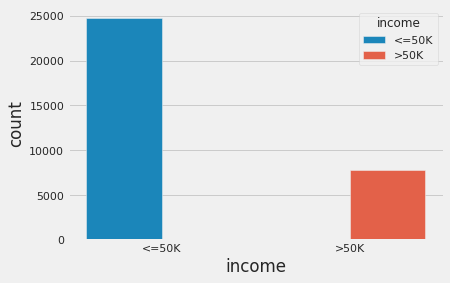

In [ ]:
# TARGET DISTRIBUTION PLOT
print(df['income'].value_counts()) 
plt.style.use('fivethirtyeight')
ax = sns.countplot(x=df.income, data=df, hue=df.income)

###**DATA PREPROCESSING**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.0+ MB


 Here we can notice that there is no information is missing.
 
 On some features, there are ‘?’, which indicated unknow information.

In [ ]:
#Checking for duplication of data
df.duplicated().sum()

24

In [ ]:
df = df.drop_duplicates()
df.shape

(32537, 15)

**Exploratory Analysis on data**

In [ ]:
# Taking a look at the target (income) 
print(f"Ratio of income above 50k : {(df['income'] == '>50K').astype('int').sum() / df.shape[0] * 100 :.2f}%")

Ratio of income above 50k : 24.09%


In [ ]:
cat_col = df.select_dtypes(include=['object']).columns
cat_col

Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country', 'income'],
      dtype='object')

In [ ]:
#Checking for '?' in categorcal features
print('% of missing values :')
for c in cat_col:
    perc = len(df[df[c] == '?']) / df.shape[0] * 100
    print(c, f'{perc:.1f} %')

% of missing values :
workclass 5.6 %
education 0.0 %
marital.status 0.0 %
occupation 5.7 %
relationship 0.0 %
race 0.0 %
sex 0.0 %
native.country 1.8 %
income 0.0 %


**Income based on sex**

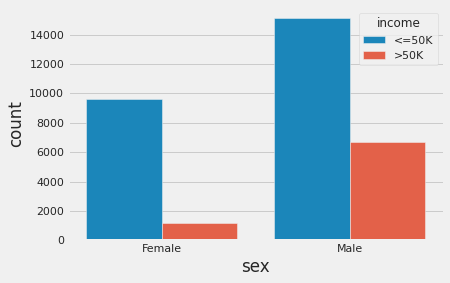

In [ ]:
plt.style.use('fivethirtyeight')
ax = sns.countplot(x=df.sex, data=df, hue=df.income)

**There are more male earning  both >50k and <50k than female. So the counts need to be normalized.**

In [ ]:
# no of female / male
no_female = (df.sex == 'Female').astype('int').sum()
no_male = (df.sex == 'Male').astype('int').sum()
no_female, no_male

(10762, 21775)

In [ ]:
# no of people earning more or less than 50k per gender
no_male_above = len(df[(df.income == '>50K') & (df.sex == 'Male')])
no_male_below = len(df[(df.income == '<=50K') & (df.sex == 'Male')])
no_female_above = len(df[(df.income == '>50K') & (df.sex == 'Female')])
no_female_below = len(df[(df.income == '<=50K') & (df.sex == 'Female')])
no_male_above, no_male_below, no_female_above, no_female_below

(6660, 15115, 1179, 9583)

In [ ]:
# normalization
no_male_above /= no_male 
no_male_below /= no_male
no_female_above /= no_female
no_female_below /= no_female
no_male_above, no_male_below, no_female_above, no_female_below

(0.3058553386911596,
 0.6941446613088404,
 0.1095521278572756,
 0.8904478721427244)

In [ ]:
print(f'Among people earning >50K  : {no_male_above / (no_male_above + no_female_above) *100 :.0f}% are Females and {no_female_above / (no_male_above + no_female_above) *100 :.0f}% are Males')
print(f'Among people earning =<50K : {no_male_below / (no_male_below + no_female_below) *100 :.0f}% are Females and {no_female_below / (no_male_below + no_female_below) *100 :.0f}% are Males')

Among people earning >50K  : 74% are Females and 26% are Males
Among people earning =<50K : 44% are Females and 56% are Males


In [ ]:
#Taking only numerical features for analysis
num_col = df.select_dtypes(include=['float', 'int']).columns
num_col

Index(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtype='object')

<ipython-input-167-6fcfb7df8b29>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

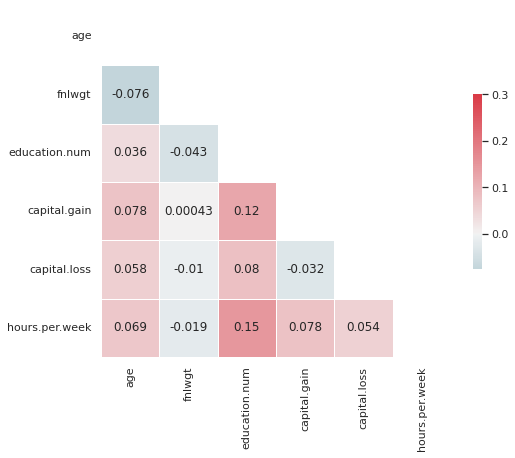

In [ ]:
sns.set(style="white")
# Compute the correlation matrix
corr = df[num_col].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

###**MODELLING**

In [ ]:
# Preprocessing on target feature
df.income.value_counts()

<=50K    24698
>50K      7839
Name: income, dtype: int64

In [ ]:
df['income'] = pd.get_dummies(df['income'], prefix='income', drop_first=True)
y = df.income
df = df.drop(columns=['income'])

In [ ]:
cat_col = df.select_dtypes(include=['object']).columns
X = pd.get_dummies(df[cat_col], drop_first=True)

In [ ]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2)

In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((26030, 94), (26030,), (6507, 94), (6507,))

In [ ]:
rfc = RandomForestClassifier(n_trees=10, bootstrap=True, max_features=5, min_samples_leaf=3,random_state=123)
rfc.fit(X_train, y_train)
acc_test = rfc.score(X_test, y_test)
acc_train = rfc.score(X_train, y_train)
y_train_pred= rfc.predict(X_train)
y_pred= rfc.predict(X_test)
print("Random Forest model")
print("train accuracy: %.2f%%" % (acc_train*100))
print("test accuracy:  %.2f%%" % (acc_test*100))

Random Forest model
train accuracy: 82.79%
test accuracy:  83.48%


####**MODEL EVALUATION**

In [ ]:
def calculate_accuracy(predictions, labels):
    predictions_correct = predictions == labels
    accuracy = predictions_correct.mean()
    
    return accuracy
def precision(y_true, y_pred):
    true_positives = sum((y_true == 1) & (y_pred == 1))
    false_positives = sum((y_true == 0) & (y_pred == 1))
    precision = true_positives / (true_positives + false_positives + 1e-7)
    return precision


def recall(y_true, y_pred):
    true_positives = sum((y_true == 1) & (y_pred == 1))
    false_negative = sum((y_true == 1) & (y_pred == 0))
    recall = true_positives / (true_positives + false_negative + 1e-7) 
    return recall

def f1_score(y_true, y_pred):
    tp = sum((y_true == 1) & (y_pred == 1))
    fp = sum((y_true == 0) & (y_pred == 1))
    tn = sum((y_true == 0) & (y_pred == 0))
    fn = sum((y_true == 1) & (y_pred == 0))
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
    return f1_score


# getting all the performane metrics and stored it in a dataframe

scores = pd.DataFrame(columns=['Model','Train_Accuracy','Train_Recall','Train_Precision','Train_F1_Score','Test_Accuracy','Test_Recall','Test_Precision','Test_F1_Score'])

def get_metrics(train_actual,train_predicted,test_actual,test_predicted,model_description,dataframe):
    train_accuracy = calculate_accuracy(train_actual,train_predicted)
    train_recall   = recall(train_actual,train_predicted)
    train_precision= precision(train_actual,train_predicted)
    train_f1score  = f1_score(train_actual,train_predicted)
    test_accuracy = calculate_accuracy(test_actual,test_predicted)
    test_recall   = recall(test_actual,test_predicted)
    test_precision= precision(test_actual,test_predicted)
    test_f1score  = f1_score(test_actual,test_predicted)
    dataframe = dataframe.append(pd.Series([model_description, train_accuracy,train_recall,train_precision,train_f1score,
                                            test_accuracy,test_recall,test_precision,test_f1score],
                                           index=scores.columns ), ignore_index=True)
    return(dataframe)

In [ ]:
# Used a customised function for getting reports
scores = get_metrics(y_train,y_train_pred,y_test,y_pred,"RandomforestClassifier",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,RandomforestClassifier,0.827891,0.486794,0.713656,0.578789,0.834793,0.48153,0.716389,0.575937


In [ ]:
calc_f1_score(y_test,y_pred)

Recall: 0.4815
Precision: 0.7164
F1 Score: 0.5759


In [ ]:
confusion_matrix(y_test,y_pred)

array([[4702,  289],
       [ 786,  730]])